In [1]:
from nltk.corpus.reader import CategorizedTaggedCorpusReader
import re
import string
from sklearn.cluster import AgglomerativeClustering
import fasttext
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import random
random.seed(2024)
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture

In [2]:
creader = CategorizedTaggedCorpusReader('./cn_news_tagged/', '.*',cat_pattern = r'(.+)/.+txt')

In [3]:
lable = []
for idx,category in enumerate(creader.categories()):
    print(idx, category)
    lable.append(category)

0 Culture
1 Education
2 Finance
3 Health
4 IT
5 Military
6 Recruit
7 Sports
8 Travel


In [4]:
zh_char = re.compile(r'[\u4e00-\u9fa5]')

In [5]:
with open('./stopwords.txt') as f:
    stopwords = f.read().strip().split()

In [6]:
extra_stopwords = ['没有','什么','不是','记者']

In [7]:
def preprocess(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stopwords + extra_stopwords and len(zh_char.findall(word)) > 1]
    return words

In [8]:
news_doc = []
news_lable = []
for category in lable:
    print('Processing {}'.format(category),end='\t')
    news_files = creader.fileids(categories=[category])
    assert len(news_files) > 100
    random.shuffle(news_files)
    for file_id in tqdm(news_files[:100]):
        doc = creader.words(fileids=[file_id])
        documents = [preprocess(document) for document in doc]
        documents = [i for i in documents if i != []]
        documents = [','.join(i) for i in documents]
        news_doc.append(documents)
        news_lable.append(category)

assert len(news_doc) == 900

Processing Culture	

100%|██████████| 100/100 [00:02<00:00, 47.29it/s]


Processing Education	

100%|██████████| 100/100 [00:01<00:00, 60.91it/s]


Processing Finance	

100%|██████████| 100/100 [00:01<00:00, 95.67it/s]


Processing Health	

100%|██████████| 100/100 [00:01<00:00, 75.10it/s]


Processing IT	

100%|██████████| 100/100 [00:00<00:00, 104.15it/s]


Processing Military	

100%|██████████| 100/100 [00:01<00:00, 81.10it/s]


Processing Recruit	

100%|██████████| 100/100 [00:01<00:00, 68.17it/s]


Processing Sports	

100%|██████████| 100/100 [00:00<00:00, 121.53it/s]


Processing Travel	

100%|██████████| 100/100 [00:00<00:00, 106.62it/s]


In [9]:
zh_embeddings = fasttext.load_model("./cc.zh.300.bin")

In [10]:
news_vec = np.zeros((900,300))

In [11]:
for idx,doc in enumerate(news_doc):
    doc_vec = zh_embeddings.get_sentence_vector(' '.join(doc))
    doc_norm = np.linalg.norm(doc_vec)
    # 模长归一化
    if doc_norm == 0:
        normalized_doc_vector = doc_vec
    else:
        normalized_doc_vector = doc_vec / doc_norm
        
    news_vec[idx] = normalized_doc_vector

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=lambda text:text, lowercase=False, min_df = 5)
news_vec_tfidf = vectorizer.fit_transform(news_doc)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
def kmeans(news_vec, true_k):
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init='auto', random_state=2024)
    model.fit(news_vec)
    doc_labels = model.labels_
    return(doc_labels)

In [15]:
true_k = 9
doc_labels = kmeans(news_vec, true_k)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [16]:
def top_term_of_cluster(true_k, news_vec_tfidf,doc_labels):
    print("Top terms per cluster:")
    terms = vectorizer.get_feature_names_out()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        doc_idxs = np.where(doc_labels==i)[0]
        cluster_vec_tfidf = news_vec_tfidf[doc_idxs].toarray()
        centroid_tfidf = np.mean(cluster_vec_tfidf, axis=0)
        order_centroid = centroid_tfidf.argsort()[::-1]
        for ind in order_centroid[:10]:
            print(' %s' % terms[ind], end='')
        print()

In [17]:
top_term_of_cluster(true_k, news_vec_tfidf, doc_labels)

Top terms per cluster:
Cluster 0: 治疗 皮肤 患者 营养 食物 女性 药物 检查 肿瘤 健康
Cluster 1: 比赛 中国 球员 冠军 中国队 新华社 主场 对手 俱乐部 联赛
Cluster 2: 旅游 游客 旅行社 航班 机场 旅客 五一 航空 航线 上海
Cluster 3: 教育 专业 大学 招生 考试 考生 学生 学校 录取 高校
Cluster 4: 公司 市场 企业 中国 用户 产品 服务 技术 发展 软件
Cluster 5: 文化 中国 生活 历史 世界 民族 社会 国家 发现 日本
Cluster 6: 公司 股东 行情 价格 市场 股份 利害 论坛 股权 机构
Cluster 7: 导弹 美国 美军 军事 俄罗斯 日本 部队 战机 飞行 作战
Cluster 8: 孩子 工作 老板 学习 喜欢 同事 公司 男人 老师 学生


In [18]:
def pca_fasttext(news_vec):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(news_vec)
    return(reduced_data)

In [19]:
reduced_data = pca_fasttext(news_vec)

In [20]:
def matplot(true_k, reduced_data, doc_labels):
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'black', 'm', 'pink', 'orange']
    for i in range(true_k):
        # 提取每个聚类的数据点
        points = reduced_data[doc_labels == i]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=f'Cluster {i}')
    plt.title('Document Clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    plt.show()

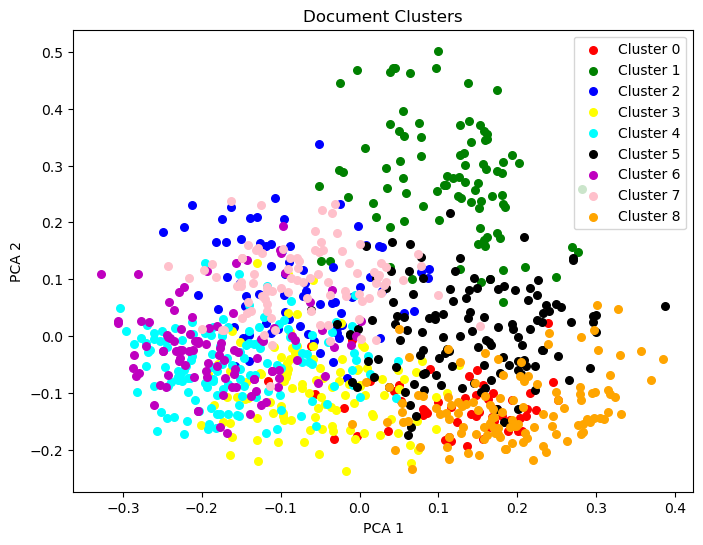

In [21]:
matplot(true_k, reduced_data, doc_labels)

In [22]:
def hac(true_k, news_vec):
    model= AgglomerativeClustering(n_clusters=true_k, metric = 'euclidean', linkage = 'complete')
    clusters = model.fit_predict(news_vec.toarray())
    return clusters

In [24]:
clusters = hac(true_k, news_vec_tfidf)

In [25]:
top_term_of_cluster(true_k, news_vec_tfidf,clusters)

Top terms per cluster:
Cluster 0: 企业 公司 教育 中国 考试 市场 价格 管理 工作 机构
Cluster 1: 生活 男人 作品 喜欢 心理 影片 教堂 感动 故事 仪式
Cluster 2: 工作 学生 食物 简历 大学 面试 毕业 人才 公司 国家队
Cluster 3: 公司 旅游 招生 大学 专业 录取 股东 手机 微软 考生
Cluster 4: 日本 中国 美国 导弹 公司 战机 美军 俄罗斯 飞行 中国队
Cluster 5: 文化 中国 市场 发展 国家 社会 创新 博客 产品 历史
Cluster 6: 孩子 行情 老板 公司 家长 老师 军事 训练 论坛 基金
Cluster 7: 比赛 主场 俱乐部 分钟 足协 对手 球员 赛季 球队 联赛
Cluster 8: 开奖 中奖 本期 软件 名牌 注数 检查 数据 平局 开出


In [26]:
def pca_tfidf(news_vec_tfidf):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(news_vec_tfidf.toarray())
    return(reduced_data)

In [27]:
reduced_data = pca_tfidf(news_vec_tfidf)

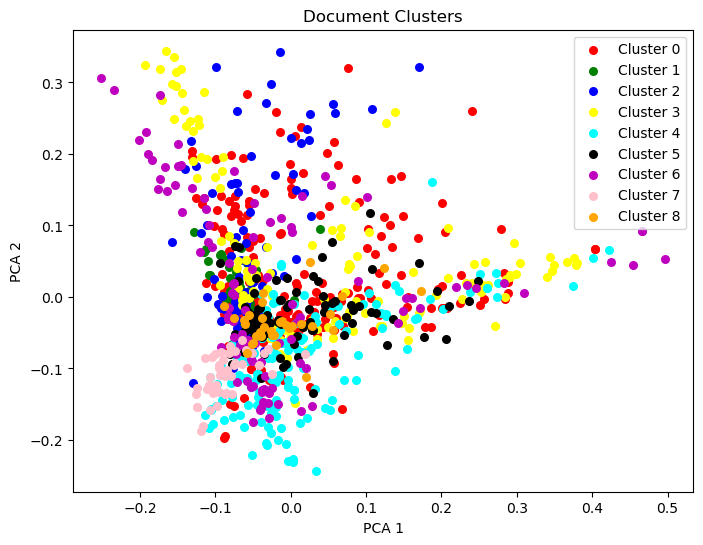

In [28]:
matplot(true_k, reduced_data, clusters)

In [29]:
def optics(news_vec):
    model = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)
    clusters = model.fit_predict(news_vec.toarray())
    return clusters

In [30]:
clusters = hac(true_k, news_vec_tfidf)

In [31]:
def gmm(news_vec, true_k):
    model = GaussianMixture(n_components= true_k, random_state=2024)
    model.fit(news_vec)
    doc_labels = model.predict(news_vec)
    return(doc_labels)
    

In [32]:
clusters = gmm(news_vec, true_k)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
